In [34]:
#!/usr/bin/env python
# coding: utf-8

# In[15]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import itertools
from operator import itemgetter

from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString

from affine import Affine

# Adjust Fontsize in all plots
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

# Import state vector file using geopandas from web
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

# Import CRB shape file
df=gpd.read_file('/glade/u/home/currierw/work/shape/crb/b9522000.shp')

def plot_helper2(ax):
    ax.set_xlim(-117,-103),ax.set_ylim(29.5,45.5)
    states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
    df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)    

# Load in a shapefile using geopandas and get the coordinate reference system (CRS)
### First explore polygons and points

In [9]:
# Outlet points for the Bureau of Reclamation

# This file was provided to met from the Bureau of Reclamation via Email
obsLoc=gpd.read_file('/glade/u/home/currierw/work/streamflow/crb/raw/CRSS_OutletPoints/OutletPoints.shp')
obsLocProj=obsLoc.to_crs(epsg=4326) # transform projection from EPSG:26912 NAD83 / UTM zone 12N to epsg 4326 - standard lat lon
obsLocProj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
!ls /glade/u/home/currierw/work/streamflow/crb/raw/CRSS_OutletPoints/

OutletPoints.dbf  OutletPoints.sbn  OutletPoints.shp	  OutletPoints.shx
OutletPoints.prj  OutletPoints.sbx  OutletPoints.shp.xml


In [15]:
!cat /glade/u/home/currierw/work/streamflow/crb/raw/CRSS_OutletPoints/OutletPoints.prj

PROJCS["NAD_1983_UTM_Zone_12N",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["false_easting",500000.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",-111.0],PARAMETER["scale_factor",0.9996],PARAMETER["latitude_of_origin",0.0],UNIT["Meter",1.0]]

In [14]:
obsLoc.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 114°W to 108°W and NAD83 by country
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [30]:
# Point File
obsLocProj.head() # head prints the top 5 things - takes up less space
# geometry files are important. this is the key to geopandas from pandas. The geometry file is used in plotting and other things

,Id,Location,LONDEC,LATDEC,geometry
0,11,"Green River near Greendale, UT",-109.422222,40.908333,POINT (-109.42073 40.90878)
1,13,"Little Snake River near Lily, CO",-108.423611,40.548611,POINT (-108.42639 40.54881)
2,12,"Yampa River near Maybell, CO",-108.032778,40.502778,POINT (-108.03579 40.50318)
3,15,"White River near Watson, UT",-109.178056,39.978889,POINT (-109.17322 39.97792)
4,14,"Duchesne River near Randlett, UT",-109.781389,40.210278,POINT (-109.78288 40.21541)


In [124]:
# Polygon file from web
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


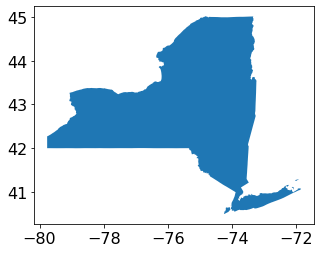

In [148]:
# Subset a file
states_gdf[states_gdf['NAME']=='New York'].plot()

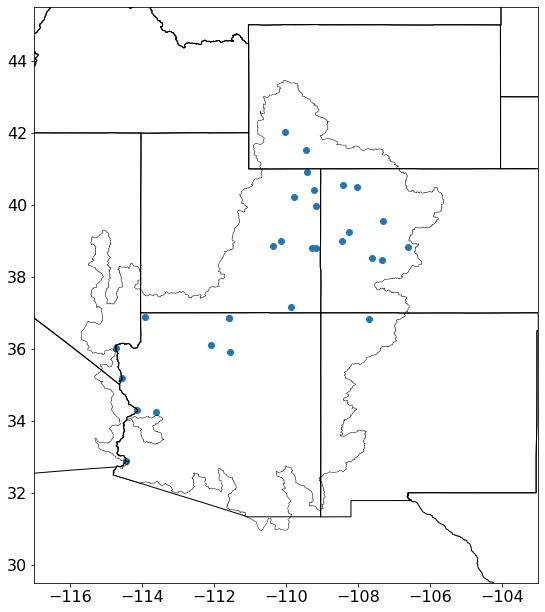

In [23]:
ax1=plt.axes((0,0,2,2))
obsLocProj.plot(ax=ax1)
# plot_helper2(ax=ax1)
ax1.set_xlim(-117,-103),ax1.set_ylim(29.5,45.5)
states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax1)
df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax1)  

In [25]:
gdf=gpd.read_file('/glade/u/home/currierw/VIC/second_watershed/CAMELS_Stream_Gauges.gpkg')

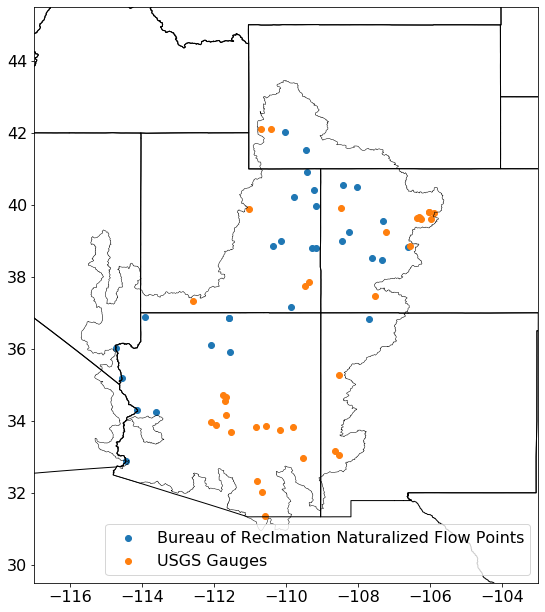

In [27]:
ax=plt.axes((0,0,2,2))
obsLocProj.plot(ax=ax,label='Bureau of Reclmation Naturalized Flow Points')
gdf.plot(ax=ax,label='USGS Gauges')
plot_helper2(ax=ax)
plt.legend(loc='lower right')

# Bring in Stream Network

In [35]:
# This was created here: /glade/u/home/currierw/mizuRoute/createRiverNetworkFile.ipynb
seg_crb=gpd.read_file("/glade/u/home/currierw/crb_river_network/crb_river_network.shp")
seg_crb.head()

,tosegment2,tosegment,seg_id,seg_id2,POI_ID,TOCOMID2,To_POI_ID,ToFTYPE,Length,start_x,...,BotElev,end_lon,end_lat,Region,tosegment_,segment_ty,seg_id_nhm,tosegmen_1,slope,geometry
0,14000028,28,1,14000001,1230725.0,0,0,None,11036.20415,-840513.8128,...,2734.0,-106.03132,40.32346,14,28,1,42706,42733,0.050561,"LINESTRING (-105.99003 40.28177, -105.98949 40..."
1,14000009,9,2,14000002,1230747.0,0,0,None,15786.31570,-893201.4272,...,2590.0,-106.60745,40.31175,14,9,1,42707,42714,0.033383,"LINESTRING (-106.64093 40.42989, -106.64066 40..."
2,14000011,11,3,14000003,1230847.0,0,0,None,6031.32459,-855004.6068,...,2745.0,-106.14530,40.29629,14,11,1,42708,42716,0.085553,"LINESTRING (-106.17124 40.34006, -106.17162 40..."
3,14000010,10,4,14000004,1230883.0,0,0,None,9273.33514,-865168.3178,...,2693.0,-106.29734,40.28614,14,10,1,42709,42715,0.058231,"LINESTRING (-106.29359 40.34677, -106.29248 40..."
4,14000007,7,5,14000005,1231205.0,0,0,None,16408.96853,-881519.9295,...,2293.0,-106.41626,40.19954,14,7,0,42710,42712,0.006094,"LINESTRING (-106.48085 40.29195, -106.48097 40..."


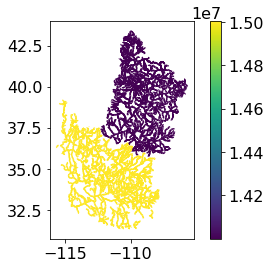

In [45]:
seg_crb.plot(column='tosegment2',legend=True)
seg_crb2=seg_crb[seg_crb['tosegment2']>=14000000]
seg_crb3=seg_crb2[seg_crb2['tosegment2']<16000000]

In [30]:
dsHRU=gpd.read_file('/glade/u/home/currierw/work/GF/nhru_CRB.gpkg')
# Get the upper colorado river basin
dsHRU2=dsHRU[dsHRU['hru_id2']>=14000000]
dsHRU3=dsHRU2[dsHRU2['hru_id2']<16000000]
dsHRU3.head()

,Dissolve,POI_ID,PROD_UNIT,hru_id_pro,hru_id,hru_x,hru_y,hru_area,hru_elev,hru_slope,...,gwstor_ini,transp_tma,dprst_et_c,va_open_ex,dprst_fr_2,fastcoef_s,va_clos_ex,hru_id2,hru_segm_1,geometry
0,3,16977382,14a,1,1,-1.122663e+06,1.486513e+06,35211.731802,1950.0,0.102955,...,2.0,1.0,1.0,1.0,0.0,0.8,1.0,14000001,14001498,"POLYGON ((-108.50438 35.69548, -108.50471 35.6..."
1,4,16977382,14a,2,2,-1.136382e+06,1.482191e+06,65077.736695,1939.0,0.087511,...,2.0,1.0,1.0,1.0,0.0,0.8,1.0,14000002,14001498,"POLYGON ((-108.56508 35.84979, -108.56542 35.8..."
2,7,16978712,14a,3,3,-1.037924e+06,1.493459e+06,41867.085894,2077.0,0.104371,...,2.0,1.0,1.0,1.0,0.0,0.8,1.0,14000003,14001500,"POLYGON ((-107.55099 35.94484, -107.55119 35.9..."
3,15,16978708,14a,4,4,-1.040670e+06,1.509666e+06,5900.009400,1984.0,0.040497,...,2.0,1.0,1.0,1.0,0.0,0.8,1.0,14000004,14001499,"POLYGON ((-107.68293 36.07956, -107.68259 36.0..."
4,19,16975752,14a,5,5,-1.054331e+06,1.493052e+06,154254.911214,2012.0,0.063502,...,2.0,1.0,1.0,1.0,0.0,0.8,1.0,14000005,14001493,"MULTIPOLYGON (((-107.70344 35.99790, -107.7037..."


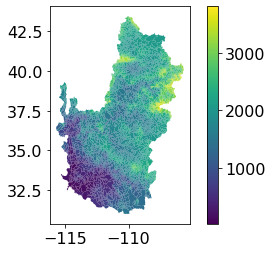

In [31]:
dsHRU3.plot(column='hru_elev',legend=True)
# ax1.set_xlim(-115,-115),ax.set_ylim(40.5,41.5)


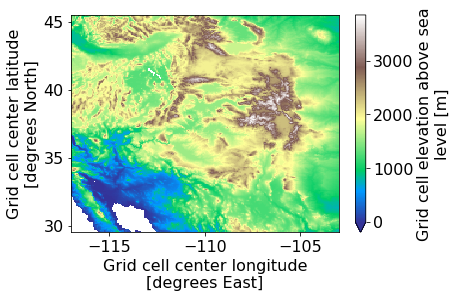

In [32]:
ds=xr.open_dataset('/glade/u/home/currierw/work/VIC/crb/LOCA_runs_cal_testNSE/crb.params.w_Masks.CONUS_MX.MOD_IGBP.mode.2000_2016.nc')
ds['elev'].plot(cmap='terrain',vmin=0)

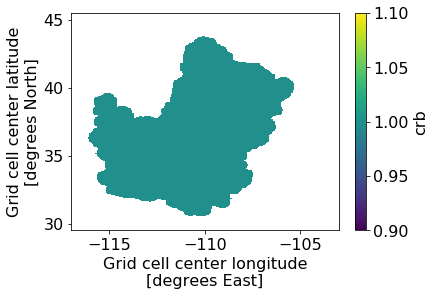

In [38]:
from affine import Affine
from rasterio import features

# copied from: https://github.com/pydata/xarray/issues/501
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

dsCoord = xr.Dataset(coords={'longitude': ds['lon'],
                          'latitude': ds['lat']})
dsCoord

# output has same dimensions as the vic parameters (256x224)
df=df.buffer(0.3)
ds['crb'] = rasterize(df.geometry, dsCoord.coords)
ds['crb'].plot()

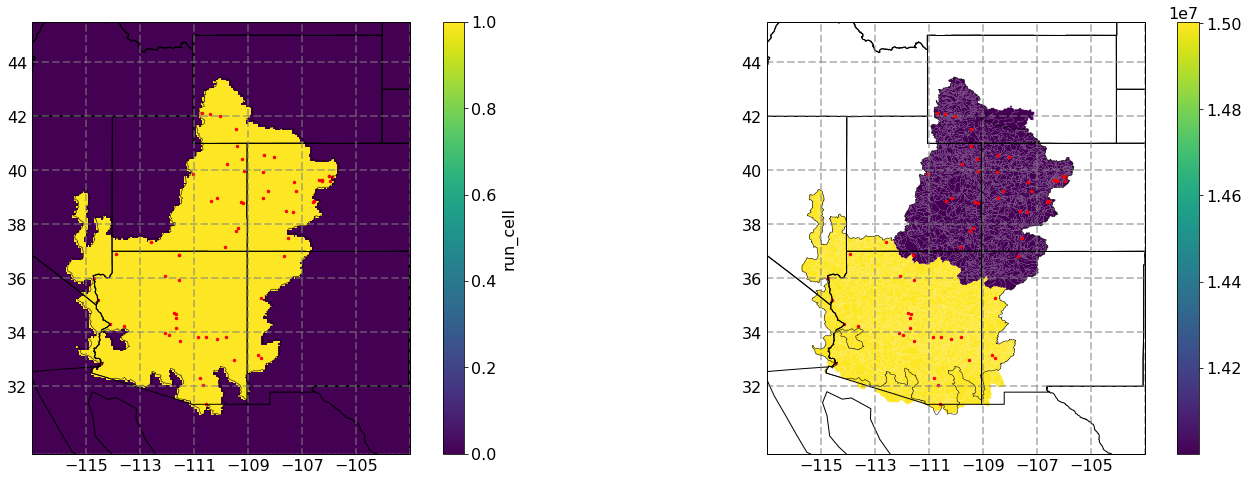

In [72]:
ds['mask']=ds['mask'].where(ds['c']!=2,1) # ignore, based on particular dataset I brough in. Needs to be 1 to bring in a appropriate existing mask
ds['run_cell']=ds['mask'].where(ds['crb']==1)
ds['run_cell']=ds['run_cell'].fillna(0).astype('int32')

ax=plt.axes((0,0,1.5,1.5),projection=ccrs.PlateCarree())
ds['run_cell'].plot()
plot_helper(ax)

ax=plt.axes((1.7,0,1.5,1.5),projection=ccrs.PlateCarree())
dsHRU3.plot(column='hru_id2',legend='True',ax=ax)
plot_helper(ax)


# Cut the whole dataset to a shapefile

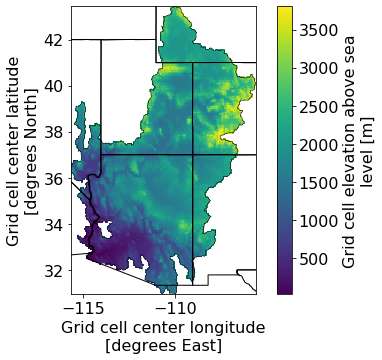

In [122]:
import xclim as xc
from xclim import subset
import rioxarray

df=df.set_crs("epsg:4326") # make sure the crs is assigned in the shape file
ds=xr.open_dataset('/glade/u/home/currierw/work/VIC/crb/LOCA_runs_cal_testNSE/crb.params.w_Masks.CONUS_MX.MOD_IGBP.mode.2000_2016.nc')
ds=ds.rio.set_crs("epsg:4326") # us rioxarray to assign a crs to the netcdf dataset

# subset the data using the polygon, use buffer size of a grid cell
dsMask = subset.subset_shape(ds,df)

ax=plt.axes((0,0,1,1))
dsMask['elev'].plot()
states_gdf.geometry.plot(facecolor='none', edgecolor='black',ax=ax)
df.geometry.plot(facecolor='none', edgecolor='black',linewidth=0.5,ax=ax)


# Find nearest streamflow network point using geometry

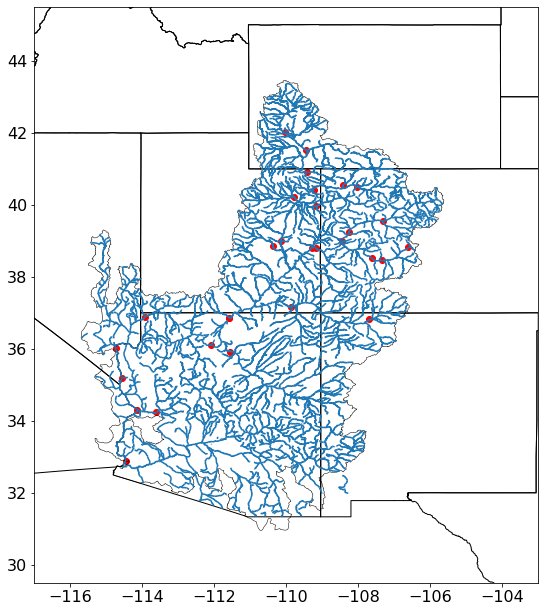

In [79]:
ax=plt.axes((0,0,2,2))
seg_crb.plot(ax=ax)
obsLocProj.plot(ax=ax,color='red')
plot_helper2(ax=ax)

In [80]:
obsLocProj.head()

,Id,Location,LONDEC,LATDEC,geometry
0,11,"Green River near Greendale, UT",-109.422222,40.908333,POINT (-109.42073 40.90878)
1,13,"Little Snake River near Lily, CO",-108.423611,40.548611,POINT (-108.42639 40.54881)
2,12,"Yampa River near Maybell, CO",-108.032778,40.502778,POINT (-108.03579 40.50318)
3,15,"White River near Watson, UT",-109.178056,39.978889,POINT (-109.17322 39.97792)
4,14,"Duchesne River near Randlett, UT",-109.781389,40.210278,POINT (-109.78288 40.21541)


In [91]:
# function to find nearest seg_id and append it to the point shape file
def ckdnearest(gdfA, gdfB, gdfB_cols=['seg_id2']):
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf


obsLocProj_2 = ckdnearest(obsLocProj, seg_crb)
obsLocProj_2.head()

,Id,Location,LONDEC,LATDEC,geometry,seg_id2,dist
0,11,"Green River near Greendale, UT",-109.422222,40.908333,POINT (-109.42073 40.90878),14001297,0.001604
1,13,"Little Snake River near Lily, CO",-108.423611,40.548611,POINT (-108.42639 40.54881),14001692,0.001781
2,12,"Yampa River near Maybell, CO",-108.032778,40.502778,POINT (-108.03579 40.50318),14000589,0.002385
3,15,"White River near Watson, UT",-109.178056,39.978889,POINT (-109.17322 39.97792),14001209,0.001059
4,14,"Duchesne River near Randlett, UT",-109.781389,40.210278,POINT (-109.78288 40.21541),14001424,0.000449


In [100]:
seg_crb.head()

,tosegment2,tosegment,seg_id,seg_id2,POI_ID,TOCOMID2,To_POI_ID,ToFTYPE,Length,start_x,...,BotElev,end_lon,end_lat,Region,tosegment_,segment_ty,seg_id_nhm,tosegmen_1,slope,geometry
0,14000028,28,1,14000001,1230725.0,0,0,None,11036.20415,-840513.8128,...,2734.0,-106.03132,40.32346,14,28,1,42706,42733,0.050561,"LINESTRING (-105.99003 40.28177, -105.98949 40..."
1,14000009,9,2,14000002,1230747.0,0,0,None,15786.31570,-893201.4272,...,2590.0,-106.60745,40.31175,14,9,1,42707,42714,0.033383,"LINESTRING (-106.64093 40.42989, -106.64066 40..."
2,14000011,11,3,14000003,1230847.0,0,0,None,6031.32459,-855004.6068,...,2745.0,-106.14530,40.29629,14,11,1,42708,42716,0.085553,"LINESTRING (-106.17124 40.34006, -106.17162 40..."
3,14000010,10,4,14000004,1230883.0,0,0,None,9273.33514,-865168.3178,...,2693.0,-106.29734,40.28614,14,10,1,42709,42715,0.058231,"LINESTRING (-106.29359 40.34677, -106.29248 40..."
4,14000007,7,5,14000005,1231205.0,0,0,None,16408.96853,-881519.9295,...,2293.0,-106.41626,40.19954,14,7,0,42710,42712,0.006094,"LINESTRING (-106.48085 40.29195, -106.48097 40..."


In [99]:
seg_crb[seg_crb['seg_id2']==obsLocProj_2['seg_id2'][15]]

,tosegment2,tosegment,seg_id,seg_id2,POI_ID,TOCOMID2,To_POI_ID,ToFTYPE,Length,start_x,...,BotElev,end_lon,end_lat,Region,tosegment_,segment_ty,seg_id_nhm,tosegmen_1,slope,geometry
1948,15001187,0,1949,14001949,20734037.0,0,0,None,6847.50849,-1.367501e+06,...,844.0,-111.60074,36.85843,14,0,7,44654,45853,0.004673,"LINESTRING (-111.54824 36.84292, -111.54844 36..."


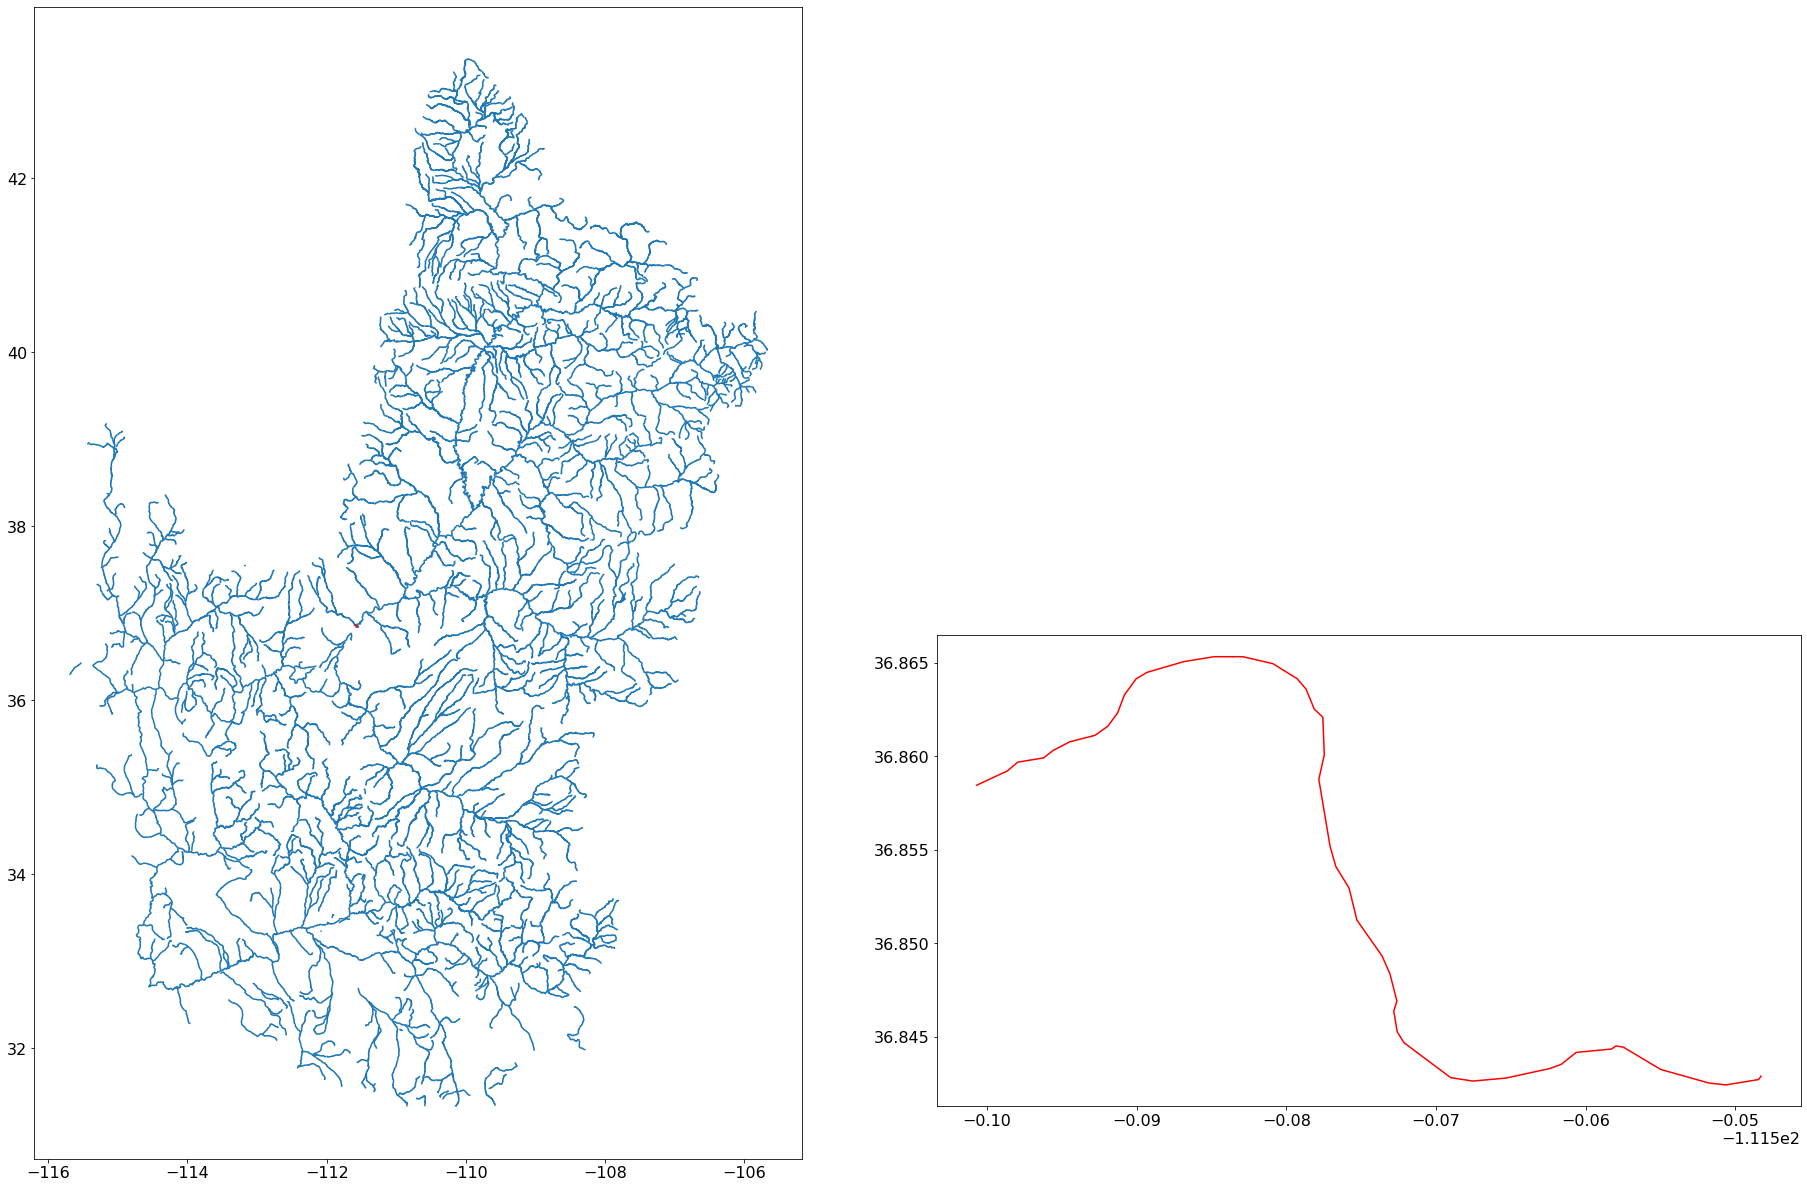

In [97]:
ax=plt.axes((0,0,4,4))
seg_crb.plot(ax=ax)
seg_crb[seg_crb['seg_id2']==obsLocProj_2['seg_id2'][15]].plot(color='red',ax=ax)

ax=plt.axes((3.2,0,2,2))
seg_crb[seg_crb['seg_id2']==obsLocProj_2['seg_id2'][15]].plot(color='red',ax=ax)


In [ ]:
# Find File from Mizuroute

In [109]:
ds=xr.open_mfdataset('/glade/u/home/currierw/work/VIC/crb/livneh_cal/route/output/Q_OUT_NC_.h.196*-01-01-00000.nc',combine='by_coords')
ds

<xarray.Dataset>
Dimensions:            (hru: 7320, seg: 3684, time: 3653)
Coordinates:
  * time               (time) datetime64[ns] 1960-01-01 ... 1969-12-31
Dimensions without coordinates: hru, seg
Data variables:
    reachID            (time, seg) int32 dask.array<chunksize=(366, 3684), meta=np.ndarray>
    basinID            (time, hru) int32 dask.array<chunksize=(366, 7320), meta=np.ndarray>
    basRunoff          (time, hru) float32 dask.array<chunksize=(366, 7320), meta=np.ndarray>
    instRunoff         (time, seg) float32 dask.array<chunksize=(366, 3684), meta=np.ndarray>
    dlayRunoff         (time, seg) float32 dask.array<chunksize=(366, 3684), meta=np.ndarray>
    sumUpstreamRunoff  (time, seg) float32 dask.array<chunksize=(366, 3684), meta=np.ndarray>
    IRFroutedRunoff    (time, seg) float32 dask.array<chunksize=(366, 3684), meta=np.ndarray>
Attributes:
    version:  v1.2

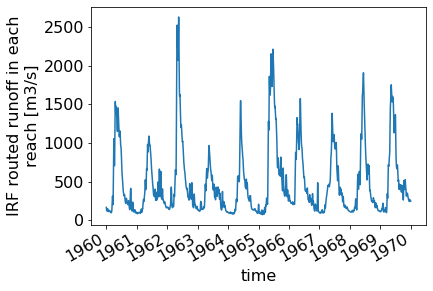

In [110]:
i=15 # Lees Ferry

# find the closes reachID in mizuroute fil to the identified reach ID from the streamflow network
dsQ=ds['IRFroutedRunoff'][:,np.argmin(np.abs((ds['reachID'][0,:]-obsLocProj_2['seg_id2'][i]))).values]
dsQ.plot()

# Multipolygons

In [44]:
states_gdf[states_gdf['NAME']=='Alabama'].geometry

0    MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...
Name: geometry, dtype: geometry

In [48]:
# these are scary and make working with polygons a pain in the ass in my humble opinion :-)
print(states_gdf[states_gdf['NAME']=='Alabama'].geometry[0][0])


POLYGON ((-88.124658 30.28364, -88.08681199999999 30.259864, -88.074854 30.249119, -88.075856 30.246139, -88.07878599999999 30.245039, -88.109432 30.242097, -88.12015100000001 30.246149, -88.137083 30.249179, -88.166569 30.249255, -88.20854 30.244807, -88.28057099999999 30.230274, -88.304773 30.228031, -88.313323 30.230024, -88.310025 30.233233, -88.299705 30.231812, -88.280781 30.233781, -88.25837 30.239595, -88.224615 30.245559, -88.17335 30.252418, -88.158303 30.252393, -88.141143 30.255024, -88.13063099999999 30.262125, -88.12472200000001 30.273541, -88.124658 30.28364))


In [47]:
print(states_gdf[states_gdf['NAME']=='Alabama'].geometry[0][1])


POLYGON ((-87.984916 35.005881, -87.87796899999999 35.005468, -87.877742 35.005512, -87.872626 35.005571, -87.853528 35.005541, -87.85341099999999 35.005576, -87.85188599999999 35.005656, -87.77358599999999 35.004946, -87.767602 35.004783, -87.75888999999999 35.004711, -87.709491 35.004089, -87.702321 35.003945, -87.700543 35.003988, -87.696834 35.003852, -87.67140499999999 35.003537, -87.664123 35.003523, -87.62502499999999 35.003732, -87.606178 35.003642, -87.428613 35.002795, -87.421543 35.002679, -87.4174 35.002669, -87.39131399999999 35.002374, -87.38107100000001 35.002118, -87.359281 35.001823, -87.349251 35.001662, -87.29918499999999 35.000915, -87.270014 35.00039, -87.23054399999999 34.999484, -87.224053 34.999327, -87.216683 34.999148, -87.210759 34.999024, -87.011174 34.995162, -87.000007 34.995121, -86.974412 34.994513, -86.972613 34.99461, -86.970236 34.994546, -86.96711999999999 34.9944, -86.86214699999999 34.991956, -86.849794 34.991924, -86.84646600000001 34.99186, -86.8

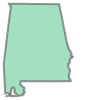

In [41]:
states_gdf[states_gdf['NAME']=='Alabama'].geometry[0]

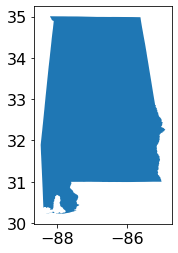

In [43]:
states_gdf[states_gdf['NAME']=='Alabama'].plot()